# 1-2 Example: Modeling Procedure for Images


### 1. Data Preparation


The cifar2 dataset is a sub-set of cifar10, which only contains two classes: airplane and automobile.

Each class contains 5000 images for training and 1000 images for testing.

The goal for this task is to train a model to classify images as airplane or automobile.

The files of cifar2 are organized as below:

![](./data/cifar2.jpg)


There are two ways of image preparation in TensorFlow.

The first one is constructing the image data generator using ImageDataGenerator in tf.keras.

The second one is constructing data pipeline using tf.data.Dataset and several methods in tf.image

The former is simpler and is demonstrated in [this article](https://zhuanlan.zhihu.com/p/67466552) (in Chinese).

The latter is the original method of TensorFlow, which is more flexible with possible better performance with proper usage.

Below is the introduction to the second method.

In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #In jpeg format
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [2]:
#Parallel pre-processing using num_parallel_calls and caching data with prefetch function to improve the performance
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

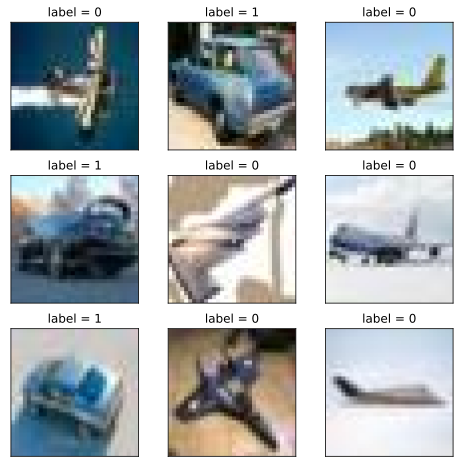

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Checking part of the samples
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [4]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


### 2. Model Definition


Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we use API functions for modeling.

In [6]:
tf.keras.backend.clear_session() #Clearing the session

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we introduce the simplist way: using internal function fit.

In [7]:
import datetime

logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 6s 57ms/step - loss: 0.4301 - accuracy: 0.8005 - val_loss: 0.3848 - val_accuracy: 0.8230
Epoch 2/10
100/100 [==============================] - 5s 46ms/step - loss: 0.3222 - accuracy: 0.8620 - val_loss: 0.2515 - val_accuracy: 0.8915
Epoch 3/10
100/100 [==============================] - 5s 48ms/step - loss: 0.2571 - accuracy: 0.8940 - val_loss: 0.2485 - val_accuracy: 0.8950
Epoch 4/10
100/100 [==============================] - 5s 49ms/step - loss: 0.2236 - accuracy: 0.9083 - val_loss: 0.1912 - val_accuracy: 0.9270
Epoch 5/10
100/100 [==============================] - 5s 47ms/step - loss: 0.1929 - accuracy: 0.9245 - val_loss: 0.1720 - val_accuracy: 0.9305
Epoch 6/10
100/100 [==============================] - 5s 47ms/step - loss: 0.1669 - accuracy: 0.9353 - val_loss: 0.1707 - val_accuracy: 0.9330
Epoch 7/10
100/100 [==============================] - 5s 48ms/step - loss: 0.1473 - accuracy: 0.944

### 4. Model Evaluation

In [8]:
#%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

In [9]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6008: logdir ./data/demomodule/ (started 2 days, 23:25:56 ago; pid 31844)


In [10]:
#Checking model in tensorboard
notebook.start("--logdir ./data/keras_model")

In [11]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.430089,0.8005,0.384820,0.8230
2,0.322172,0.8620,0.251545,0.8915
3,0.257112,0.8940,0.248472,0.8950
4,0.223557,0.9083,0.191244,0.9270
5,0.192865,0.9245,0.172041,0.9305
6,0.166899,0.9353,0.170723,0.9330
7,0.147336,0.9443,0.176652,0.9265
8,0.136390,0.9470,0.161333,0.9395
9,0.119297,0.9529,0.165877,0.9365


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

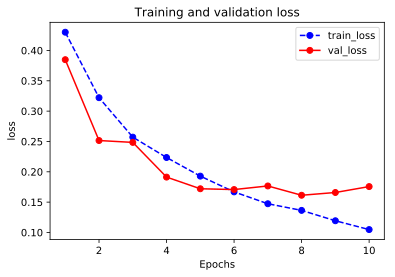

In [13]:
plot_metric(history,"loss")

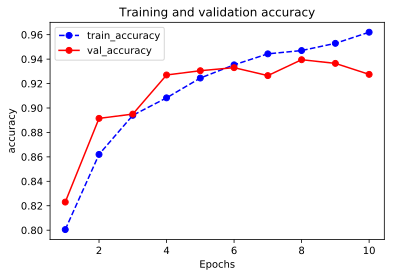

In [14]:
plot_metric(history,"accuracy")

In [15]:
#Evaluating data using model.evaluate function
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 12ms/step - loss: 0.1756 - accuracy: 0.9275
0.17563895098865032 0.9275


### 5. Model Application

We can use model.predict(ds_test) for prediction.

We can also use model.predict_on_batch(x_test) to predict a batch of data.

In [16]:
model.predict(ds_test)

array([[5.5342877e-01],
       [9.6280634e-01],
       [9.9671257e-01],
       ...,
       [1.4167616e-01],
       [3.4373655e-04],
       [9.1297424e-04]], dtype=float32)

In [17]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[8.4109956e-01]
 [9.9916232e-01]
 [5.5581123e-01]
 [1.4196011e-03]
 [1.8454519e-06]
 [4.1419727e-01]
 [1.4913726e-01]
 [4.1271173e-06]
 [9.9971563e-01]
 [8.6283803e-01]
 [9.9998522e-01]
 [8.8707858e-01]
 [8.9674465e-02]
 [2.7287719e-05]
 [1.0562064e-02]
 [7.0271676e-06]
 [1.1304284e-03]
 [1.1318375e-04]
 [9.9996042e-01]
 [7.7243763e-01]], shape=(20, 1), dtype=float32)


### 6. Model Saving

We recommend model saving with the original way of TensorFlow.

In [18]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [19]:
# Saving model structure and parameters to a file, so the model allows cross-platform deployment

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.
20/20 [==============================] - 0s 16ms/step - loss: 0.1756 - accuracy: 0.9275


[0.1756384875625372, 0.9275]